# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

## A probar: PERCEPTRON - LOGISTIC REGRESSION - SVM -

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve

## LECTURA Y LIMPIEZA DEL DATASET

In [3]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [4]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking","creatinine_phosphokinase","platelets"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  76.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

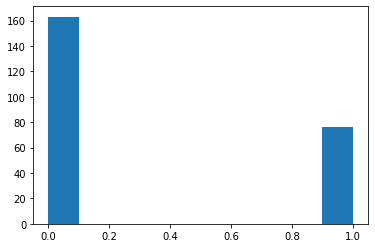

In [5]:
plt.hist(df_cleaned["DEATH_EVENT"]) # Desbalanceados => Usamos métrica de scoring F1, aunque RECALL sería recomendable si no queremos diágnosticos fallidos. VER

In [6]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [7]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

In [8]:
scaler.var_ # ESTA VARIANZA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

array([134.87676234, 141.47813931,   1.48949678,  21.75187084])

In [9]:
scaler.mean_ # ESTA MEDIA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

array([ 60.22862304,  37.58638743,   1.48623037, 136.37172775])

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [10]:
sss = StratifiedShuffleSplit(40)

# LOGISTIC REGRESSION

### La teoría indica que el Logistic Regressor no tiene hyperparametros q valgan la pena tunear mas allá del penalty o un poco el "C".

In [95]:
hyperparam = {"poly__degree":[n for n in range(5,9)],"regressor__C":[n for n in np.logspace(-8.0,-5.0, num=25)]}

lr_model = Pipeline([["poly",PolynomialFeatures(degree=1)],["regressor",LogisticRegression(fit_intercept=False, C=1.0, penalty="l2",max_iter=30000)]])

lr_grilla = GridSearchCV(lr_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)

lr_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=30, random_state=None, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['regressor',
                                        LogisticRegression(fit_intercept=False,
                                                           max_iter=30000)]]),
             n_jobs=-1,
             param_grid={'poly__degree': [5, 6, 7, 8],
                         'regressor__C': [1e-08, 1.333521432163324e-08,
                                          1.7782794100389228e-08,...
                                          7.498942093324559e-08, 1e-07,
                                          1.333521432163324e-07,
                                          1.7782794100389227e-07,
                                          2.3713737056616554e-07,
                                          3.162277660168379e-07,
                                      

In [96]:
lr_model = lr_grilla.best_estimator_
lr_model.predict_proba(feat_train)[1,:]

array([0.50246938, 0.49753062])

In [97]:
print(lr_grilla.best_params_)
print("Grilla Best Score: {}".format(lr_grilla.best_score_))

print("Cross Validation Score: {}".format(cross_val_score(lr_model, feat_train, targ_train,cv=sss,scoring="f1").mean()))

{'poly__degree': 7, 'regressor__C': 3.162277660168379e-06}
Grilla Best Score: 0.674398656898657
Cross Validation Score: 0.5986843711843711


In [104]:
lr_predicted = cross_val_predict(lr_model,feat_train,targ_train,cv=40)

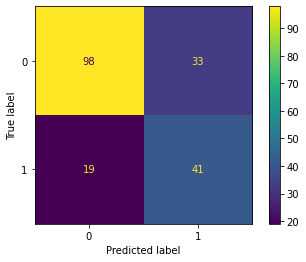

In [105]:
cm = confusion_matrix(targ_train, lr_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

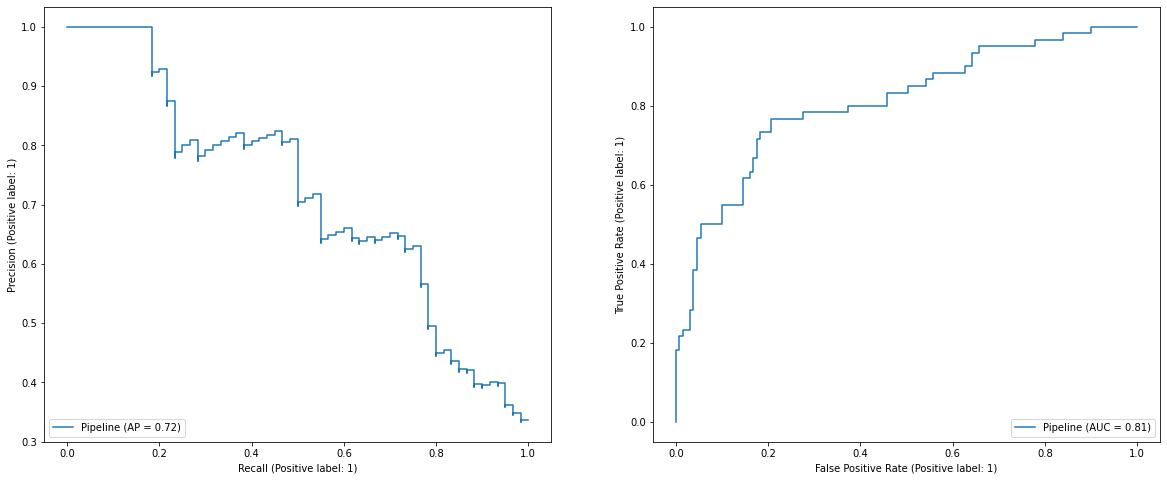

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(lr_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(lr_model, feat_train, targ_train,ax=ax2)

---

# SUPPORT VECTOR MACHINES

In [111]:
hyperparam = {"poly__degree":[n for n in range(1,7)],"SVC__C":[n for n in np.logspace(-8.0,-3.0, num=25)]}

svml_model = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["SVC",LinearSVC(loss='hinge', C=1.0, fit_intercept=False, penalty='l2', max_iter=30000)]])

svml_grilla = GridSearchCV(svml_model,hyperparam,cv=sss,scoring="f1",n_jobs=-1)

svml_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=30, random_state=None, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['SVC',
                                        LinearSVC(fit_intercept=False,
                                                  loss='hinge',
                                                  max_iter=30000)]]),
             n_jobs=-1,
             param_grid={'SVC__C': [1e-08, 1.6155980984398728e-08,
                                    2.6101572156825384e-08,
                                    4.2169650342858225e-08,
                                    6.8129206...
                                    7.498942093324558e-07, 1.21152765862859e-06,
                                    1.9573417814876616e-06,
                                    3.162277660168379e-06,
                                    5.108969774506934e-06, 8.25404185268019e-06,
           

In [119]:
svml_model = svml_grilla.best_estimator_

In [120]:
print(svml_grilla.best_params_)
print("Grilla Best Score: {}".format(svml_grilla.best_score_))

print("Cross Validation Score: {}".format(cross_val_score(svml_model, feat_train, targ_train,cv=sss,scoring="f1").mean()))

{'SVC__C': 2.1544346900318867e-05, 'poly__degree': 3}
Grilla Best Score: 0.6252312937607056
Cross Validation Score: 0.5513039411568824


In [121]:
svml_predicted = cross_val_predict(svml_model,feat_train,targ_train,cv=40)

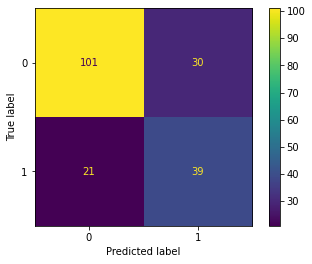

In [122]:
cm = confusion_matrix(targ_train, svml_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

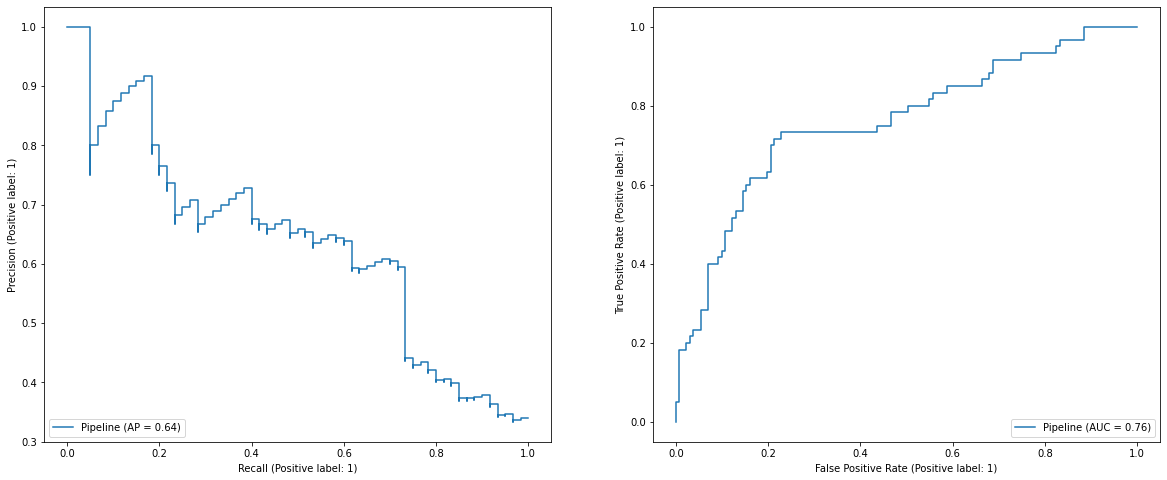

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svml_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svml_model, feat_train, targ_train,ax=ax2)

In [19]:
hyperparam = {"kernel":["rbf","poly","linear","sigmoid"],"C":[n for n in np.logspace(0,1.0, num=25)],"gamma":[n for n in np.logspace(-2.0,0, num=25)]}

svm_grilla = GridSearchCV(SVC(),hyperparam,cv=sss,scoring="f1",n_jobs=-1)

svm_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=40, random_state=None, test_size=None,
            train_size=None),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 1.1006941712522096, 1.2115276586285884,
                               1.333521432163324, 1.4677992676220695,
                               1.615598098439874, 1.7782794100389228,
                               1.9573417814876601, 2.154434690031884,
                               2.371373705661655, 2.610157215682537,
                               2.872984833353664...
                                   0.046415888336127774, 0.05623413251903491,
                                   0.06812920690579612, 0.08254041852680181,
                                   0.1, 0.12115276586285882, 0.1467799267622069,
                                   0.1778279410038923, 0.21544346900318834,
                                   0.2610157215682536, 0.31622776601683794,
                                   0.3831186849

In [20]:
svm_model = svm_grilla.best_estimator_
print(svm_grilla.best_params_)
print("Grilla Best Score: {}".format(svm_grilla.best_score_))

print("Cross Validation Score: {}".format(cross_val_score(svm_model, feat_train, targ_train,cv=sss,scoring="f1").mean()))

{'C': 2.8729848333536645, 'gamma': 0.1, 'kernel': 'sigmoid'}
Grilla Best Score: 0.5510299422799423
Cross Validation Score: 0.5602107614607614


In [27]:
svm_predicted = cross_val_predict(svm_model,feat_train,targ_train,cv=40)

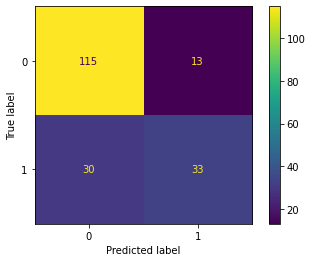

In [28]:
cm = confusion_matrix(targ_train, svm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

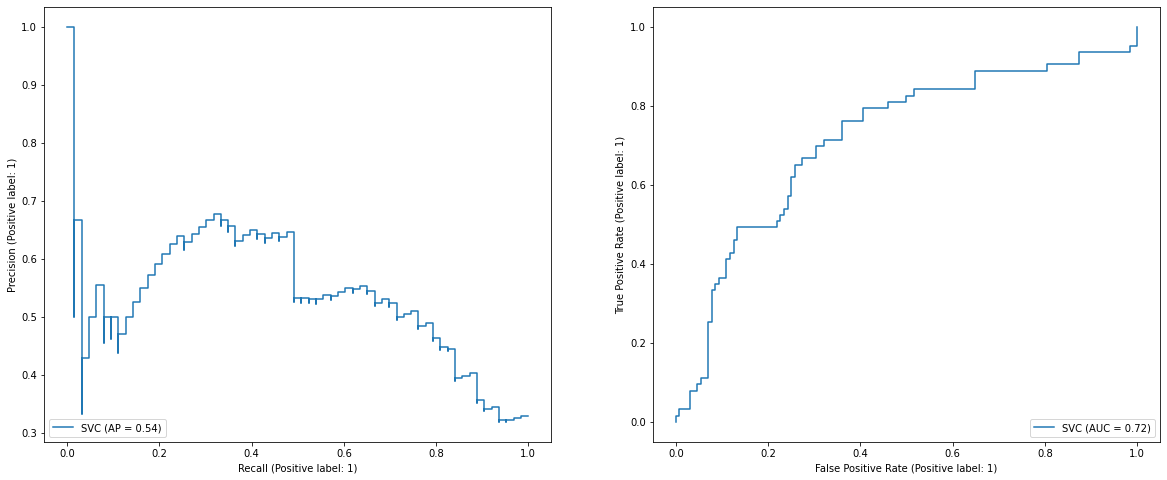

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svm_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svm_model, feat_train, targ_train,ax=ax2)

# DECISION TREE

max_depth: por defecto es None, controla la profundidad del arbol.
min_samples_split: establece el minimo numero de muestras que debe tener un nodo para poder seguir partiendolo.
min_samples_leaf: el minimo numero de muestras que debe tener una hoja (ie nodo final).
min_weight_fraction_leaf: la minima fraccion pesada de muestras que debe poseer una hoja.
max_leaf_nodes: maxima cantidad de hojas.
max_features: maxima cantidad de features evaluados en un splitting.

In [59]:
hyperparam = {"max_depth":[n for n in range(40,60)],"min_samples_split":[n for n in range(5,15)],"max_leaf_nodes":[n for n in range(5,20)]}

dt_grilla = GridSearchCV(DecisionTreeClassifier(),hyperparam,cv=sss,scoring="f1",n_jobs=-1)

dt_grilla.fit(feat_train,targ_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=40, random_state=None, test_size=None,
            train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                       50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                            15, 16, 17, 18, 19],
                         'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                               14]},
             scoring='f1')

In [60]:
dt_model = dt_grilla.best_estimator_
print(dt_grilla.best_params_)
print("Grilla Best Score: {}".format(dt_grilla.best_score_))

print("Cross Validation Score: {}".format(cross_val_score(dt_model, feat_train, targ_train,cv=sss,scoring="f1").mean()))

{'max_depth': 59, 'max_leaf_nodes': 17, 'min_samples_split': 9}
Grilla Best Score: 0.5735700451509275
Cross Validation Score: 0.5735038613347436


In [61]:
dt_predicted = cross_val_predict(dt_model,feat_train,targ_train,cv=40)

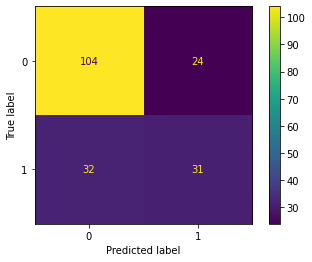

In [62]:
cm = confusion_matrix(targ_train, dt_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

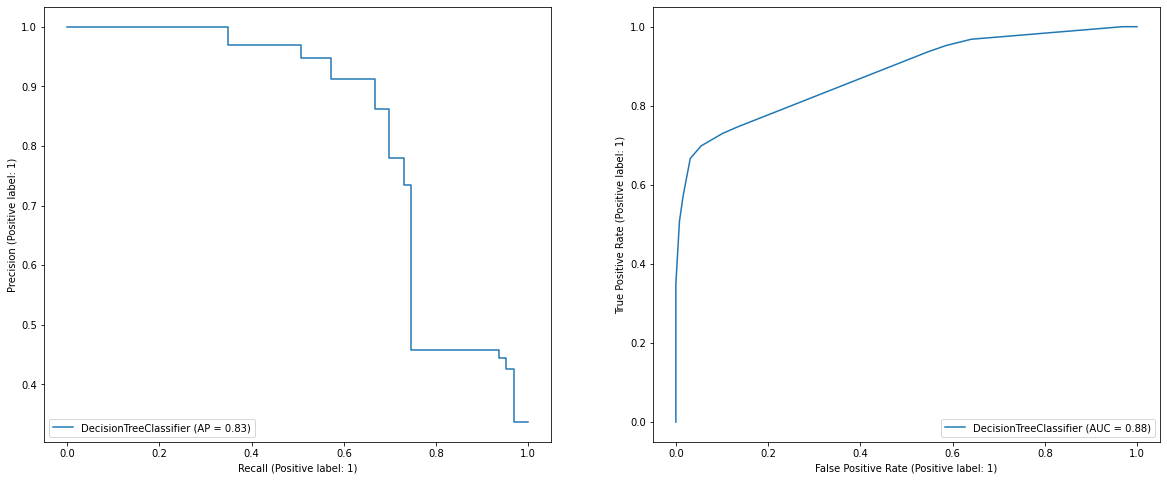

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(dt_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(dt_model, feat_train, targ_train,ax=ax2)